# Loading all relevant libraries and functions

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from itertools import combinations

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Models

import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import randint
from sklearn.datasets import make_classification
from sklearn.utils.multiclass import unique_labels

import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

##### Loading Data

In [67]:
url = '/Users/aashmanrastogi/Desktop/Math 42/FINAL PROJECT/archive/application_record.csv'
url1 = '/Users/aashmanrastogi/Desktop/Math 42/FINAL PROJECT/archive/credit_record.csv'
app = pd.read_csv(url)
cred = pd.read_csv(url1)


###### Viewing rows for both datasets

In [68]:
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [69]:
cred.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


###### Merging the datasets based on common column ( ID )

In [70]:
merge = pd.merge(cred,app,on = "ID" , how = "inner")
merge.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008804,-1,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008804,-2,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
3,5008804,-3,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
4,5008804,-4,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


# Data Cleaning and Preparation

In [71]:
np.random.seed(1234)

merge.rename(columns={'NAME_FAMILY_STATUS': 'IsMarried'}, inplace=True)
train, test = train_test_split(merge, test_size=0.2)
'''
We first spilt our data into testing and training set. 
'''

'''
The function "prep_data" is designed to clean and transform the input dataset into a 
format suitable for training and evaluating machine learning models
'''

def prep_data(data):
    
    df = data.copy()
    df = df.dropna()

    le = LabelEncoder()
    
    df["CODE_GENDER"] = le.fit_transform(df["CODE_GENDER"])
    df["FLAG_OWN_CAR"] = le.fit_transform(df["FLAG_OWN_CAR"])
    df["FLAG_OWN_REALTY"] = le.fit_transform(df["FLAG_OWN_REALTY"])
    
    sentiment_mapping = {'X': 1, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, 'C': 1}
    df['STATUS'] = df['STATUS'].map(sentiment_mapping)
    
    maps = {
        'Academic degree': 4, 
        'Higher education': 4, 
        'Incomplete higher': 3, 
        'Secondary / secondary special': 2,
        'Lower secondary': 1}
    
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(maps)

    maps2 = {'Married': 1, 
             'Single / not married': 0, 
             'Civil marriage': 1, 
             'Separated': 0, 
             'Widow': 0}
    
    df['IsMarried'] = df['IsMarried'].map(maps2)
    
    maps3 = {'Working': 1, 
             'Commercial associate': 1, 
             'State servant': 1, 
             'Pensioner': 1, 
             'Student': 0}
    
    df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map(maps3)
    
    x = df.drop(["NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "ID","STATUS"], axis=1)
    y = df["STATUS"]
    
    return x, y

'''
The function starts by creating a copy of the original dataset to avoid modifying the original data. This ensures 
that any changes made during data preparation are applied to the copied dataset.

The function drops rows that contain NaN (missing) values. This step is important because many machine learning 
algorithms cannot handle missing data, and dropping rows with missing values is a common approach to 
handle this issue. By removing rows with NaN values, we ensure that the dataset is complete and ready for 
further processing.

The function proceeds to transform categorical columns into numerical ones. This step is necessary because 
most machine learning algorithms require numerical input. 
There are two types of encoding used in this function:

a. Label Encoding (Few Unique Values): For columns that have a small number of unique values, the function applies
                                       label encoding. Label encoding assigns a unique numeric label to each 
                                       distinct category in the column. This transformation allows the algorithm 
                                       to understand the categorical data by representing it numerically.
b. Custom Label Encoding (More Intuitive Meaning): For columns where the categorical values have a more intuitive 
                                        meaning or order, the function defines custom labels and maps them to the 
                                        corresponding categories. This ensures that the numerical representation 
                                        retains the semantic meaning of the original categorical values.
                                        
Finally, the function prepares the independent variables (features) and the dependent variable (predictor) to be 
used in the machine learning models. It removes any unnecessary columns that are not relevant to the prediction 
task. The independent variables are assigned to the variable "x," while the dependent variable is assigned to the
variable "y."

'''

x_train, y_train = prep_data(train)     # get data into x_train and y_train from training set
x_test,y_test = prep_data(test)         # get data into x_test and y_test from testing set

#### checking structure of the split datasets

In [72]:
print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

(430214, 16) (430214,)
(107453, 16) (107453,)


In [73]:
x_test.head()

,MONTHS_BALANCE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,IsMarried,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
99062,-51,0,0,1,0,247500.0,1,2,1,-16340,-8647,1,0,0,0,2.0
730461,-23,0,0,1,1,121500.0,1,4,1,-11981,-2965,1,1,0,0,3.0
527997,-25,0,0,1,1,90000.0,1,2,0,-12037,-2706,1,0,0,0,2.0
18953,-7,1,1,1,0,360000.0,1,4,1,-19958,-7465,1,0,0,0,2.0
423587,-2,0,1,0,0,180000.0,1,2,1,-18341,-5574,1,1,1,0,2.0


# Feature Selection

In [74]:
variance_filter = VarianceThreshold()
variance_filter.fit(x_train)
feature_high_var = variance_filter.get_support(indices=True)
x_train = x_train.iloc[:, feature_high_var]

'''
x_train is updated to only include the columns (features) that have a variance above the threshold set by 
VarianceThreshold. This feature selection step helps remove low-variance features, reducing the dimensionality of
the dataset and potentially improving the performance of our machine learning models by focusing on more 
informative features.
'''

In [80]:
selector = SelectKBest(score_func=f_classif, k=10)

X_new = selector.fit_transform(x_train, y_train)

mask = selector.get_support()

new_features = []

for bool, feature in zip(mask, x_train.columns):
    if bool:
        new_features.append(feature)
        
print('The best features are: ', new_features)

'''
The code above determines the 10 best features selected by the SelectKBest method from our dataset. The selected 
feature names are also printed for reference. This feature selection step helps further reduce the dimensionality 
of the data by focusing on the most informative features according to the f_classif score function.

SelectKBest operates on the principle of evaluating the relationship between each feature and the target variable 
independently, without considering the interactions between features.

'''

The best features are:  ['MONTHS_BALANCE', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'IsMarried', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_EMAIL']


In [81]:
# set x_train and x_test so that they only contain columns usefull for our prediction
cols= new_features
x_train = x_train[cols]
x_test = x_test[cols]

# 1. Decision Tree

In [12]:
'''
We train a decision tree classifier model on the training data, make predictions on the test data, and 
calculate the accuracy of the predictions.

Decision trees are a good choice for credit card approval prediction due to their interpretability, ability to 
handle nonlinear relationships and mixed data types, capturing of interaction effects, and scalability. 
They are computationally efficient and can handle large datasets, however, not the best if we have high 
dimensionality in our datset
'''

model = DecisionTreeClassifier()

model.fit(x_train,y_train)
y_pred = model.predict(x_test)

score_pred = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % score_pred)

Accuracy: 0.683006


###### Confusion Matrix to show accuracy and errors

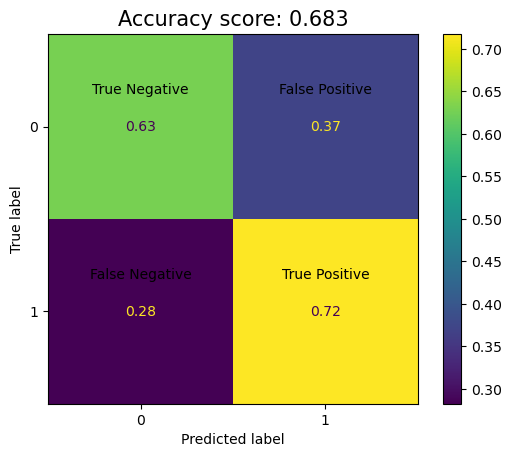

In [13]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]


texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
    
plt.title(f"Accuracy score: {score_pred.round(4)}", size = 15)
plt.show()

# 2. Logistic Regression

In [14]:
'''
We train a Logistic Regression model on the training data, make predictions on the test data, and 
calculate the accuracy of the predictions.

Logistic regression is a good choice for credit card approval prediction due to its ability to handle binary 
classification problems, and large datasets. Logistic regression provides a probabilistic framework that allows 
for the interpretation of feature coefficients, enabling us to understand the impact of different factors on 
credit card approval. It is well-suited for binary classification tasks, where the goal is to predict whether a 
credit card application will be approved or not. However, it has its limitations as it does not take into account 
non linear relationships between features and is sensitive to outliers. 
'''

LR = LogisticRegression()

LR.fit(x_train,y_train)
y_pred = LR.predict(x_test)

score_pred = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % score_pred)

Accuracy: 0.613943


###### Confusion Matrix to show accuracy and errors

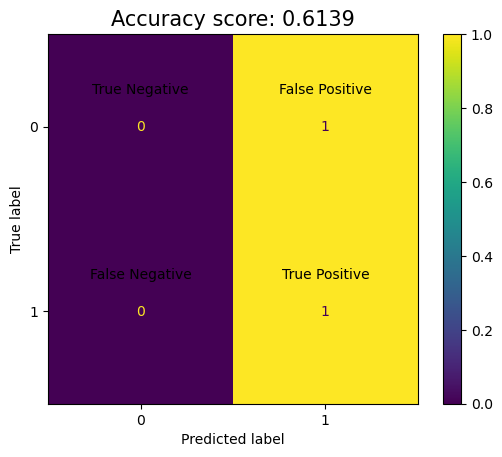

In [15]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]


texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
    
plt.title(f"Accuracy score: {score_pred.round(4)}", size = 15)
plt.show()

# 3. Random Forest

In [16]:
'''
We train a Random Forest model on the training data, make predictions on the test data, and 
calculate the accuracy of the predictions.


Random Forest is a good choice for credit card approval prediction due to its ability to handle complex 
relationships, and provide robust predictions. Random Forest also performs well with imbalanced data by balancing 
class weights. It provides reliable predictions and reduces the risk of overfitting. However, Random Forest models 
can be computationally expensive and have longer training times compared to simpler models. Need hyperparameters 
tuned to get accurate result and are generally more effective when dealing with lower-dimensional data.
'''

forest = RandomForestClassifier()

forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

score_pred = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % score_pred)

Accuracy: 0.708738


###### Confusion Matrix to show accuracy and errors

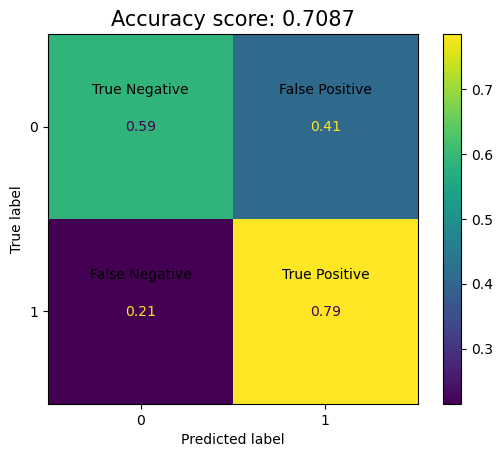

In [17]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]

texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
    
plt.title(f"Accuracy score: {score_pred.round(4)}", size = 15)
plt.show()

# 4. Gaussian Naive Bayes

In [18]:
'''
We train a Gaussian Naive Bayes model on the training data, make predictions on the test data, and 
calculate the accuracy of the predictions.

Gaussian Naive Bayes is a good choice for credit card approval prediction due to its simplicity, efficiency, and 
ability to handle continuous and normally distributed features. However, it assumes independence between features,
which may not hold in real-world scenarios. Additionally, it may not capture complex relationships between 
features or handle interactions effectively
'''

nb_classifier = GaussianNB()

nb_classifier.fit(x_train, y_train)
y_pred = nb_classifier.predict(x_test)

score_pred = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % score_pred)

Accuracy: 0.625334


###### Confusion Matrix to show accuracy and errors

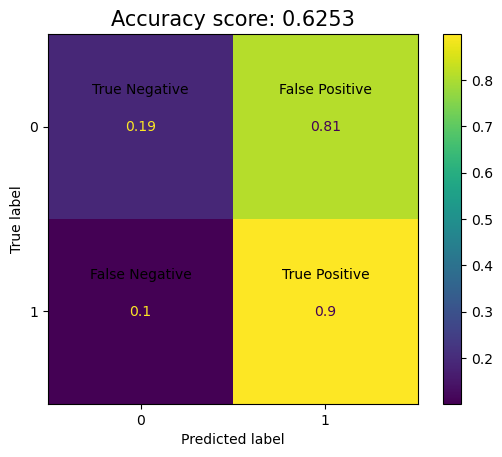

In [19]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]

texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
    
plt.title(f"Accuracy score: {score_pred.round(4)}", size = 15)
plt.show()

# 5. XG Boost

In [20]:
'''
We train a XG Boost model on the training data, make predictions on the test data, and 
calculate the accuracy of the predictions.

XGBoost (Extreme Gradient Boosting) is a powerful algorithm for credit card approval prediction due to its ability
to handle complex relationships, handle imbalanced data, and provide high predictive accuracy. XGBoost employs an 
ensemble of decision trees and incorporates gradient boosting techniques, allowing it to capture nonlinear 
interactions, feature importance, and handle large feature spaces. However, XGBoost can be computationally 
intensive and requires careful tuning of hyperparameters to achieve optimal performance. 
'''

xgb_model = xgb.XGBClassifier()

xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

score_pred = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % score_pred)

Accuracy: 0.701423


###### Confusion Matrix to show accuracy and errors

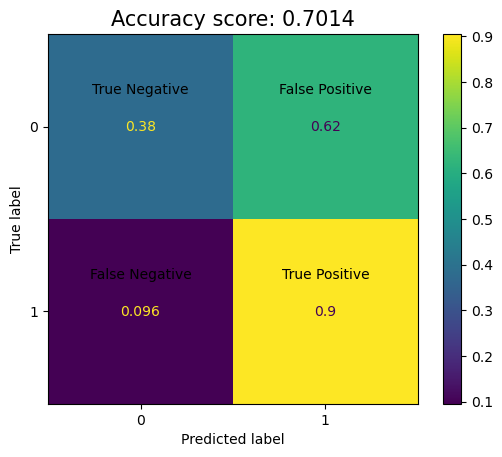

In [21]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]


texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
plt.title(f"Accuracy score: {score_pred.round(4)}", size = 15)
plt.show()

# 6. K-Nearest Neighbors

In [22]:
# Normalize Data for KNN

'''
Normalizing the feature data using MinMaxScaler is necessary for KNN to ensure that all features contribute 
equally to the distance calculations, regardless of their original scales. 
Scaled values are now between 0 and 1


'''
scaler = MinMaxScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [23]:
'''
We train a KNN model on the training data, make predictions on the test data, and 
calculate the accuracy of the predictions.

K-nearest neighbors (KNN) is a good choice for credit card approval prediction due to its simplicity, 
non-parametric nature, and ability to capture local patterns in the data. KNN makes predictions based on the 
similarity of a new data point to its nearest neighbors in the training set. However, KNN can be sensitive to the 
choice of distance metric and the number of neighbors (K), and it may not perform well with high-dimensional or 
sparse datasets. Additionally, the prediction process can be computationally expensive, especially with large 
training sets. 
'''

knn = KNeighborsClassifier()

knn.fit(x_train_normalized, y_train)
y_pred = knn.predict(x_test_normalized)

score_pred = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % score_pred)

Accuracy: 0.713987


###### Confusion Matrix to show accuracy and errors

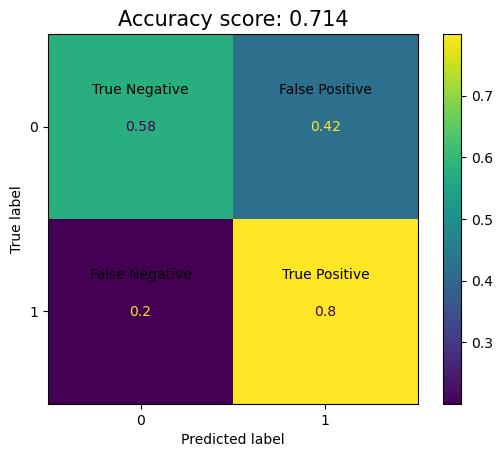

In [24]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]

texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
    
plt.title(f"Accuracy score: {score_pred.round(4)}", size = 15)
plt.show()

# 6 (a). KNN Hyperparameter Optimization

In [25]:
'''
We perform a grid search to find the best hyperparameters for a KNN classifier using cross-validation. We then 
trains a new KNN classifier with the best hyperparameters, make predictions on the test set, and calculate the 
accuracy of the predictions.

What is Manhattan Distance?
The metric determines how the distance is computed in KNN. In the case of "Manhattan" distance, the distance 
between two points is calculated as the sum of the absolute differences between their corresponding feature values.
It measures the total length of the sides of a right-angled triangle when moving from one point to another in a 
grid-like fashion.
'''

hyperparameters = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

scoring = 'accuracy'

param_grid = hyperparameters

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring=scoring)
grid_search.fit(x_train_normalized, y_train)

best_params = grid_search.best_params_

knn = KNeighborsClassifier(**best_params)
knn.fit(x_train_normalized, y_train)
y_pred = knn.predict(x_test_normalized)
accuracy = accuracy_score(y_test, y_pred)

print("Best hyperparameters:", best_params)
print("Test set accuracy:", accuracy)

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9}
Test set accuracy: 0.7405470298642197


###### Confusion Matrix to show accuracy and errors

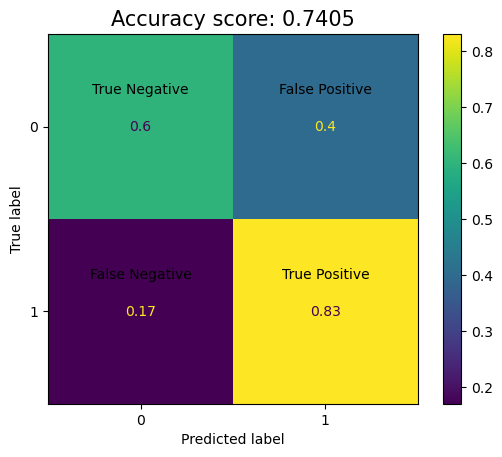

In [26]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = unique_labels(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax)

y_positions = [-.2, -.2, .8, .8]
x_positions = [0, 1, 0, 1]

texts = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for x, y, text in zip(x_positions, y_positions, texts):
    ax.text(x, y, text, va='center', ha='center', color='black', fontsize=10)
    
plt.title(f"Accuracy score: {accuracy.round(4)}", size = 15)
plt.show()

The best model we arrived on for classification was a KNN model using Manhattan distance and 9
neighbors. It resulted in an accuracy of approximately 0.741